Loading and preprocessing data...
Successfully loaded Sheet1
Successfully loaded Feederwise data
Successfully preprocessed data

Generating and displaying visualizations...


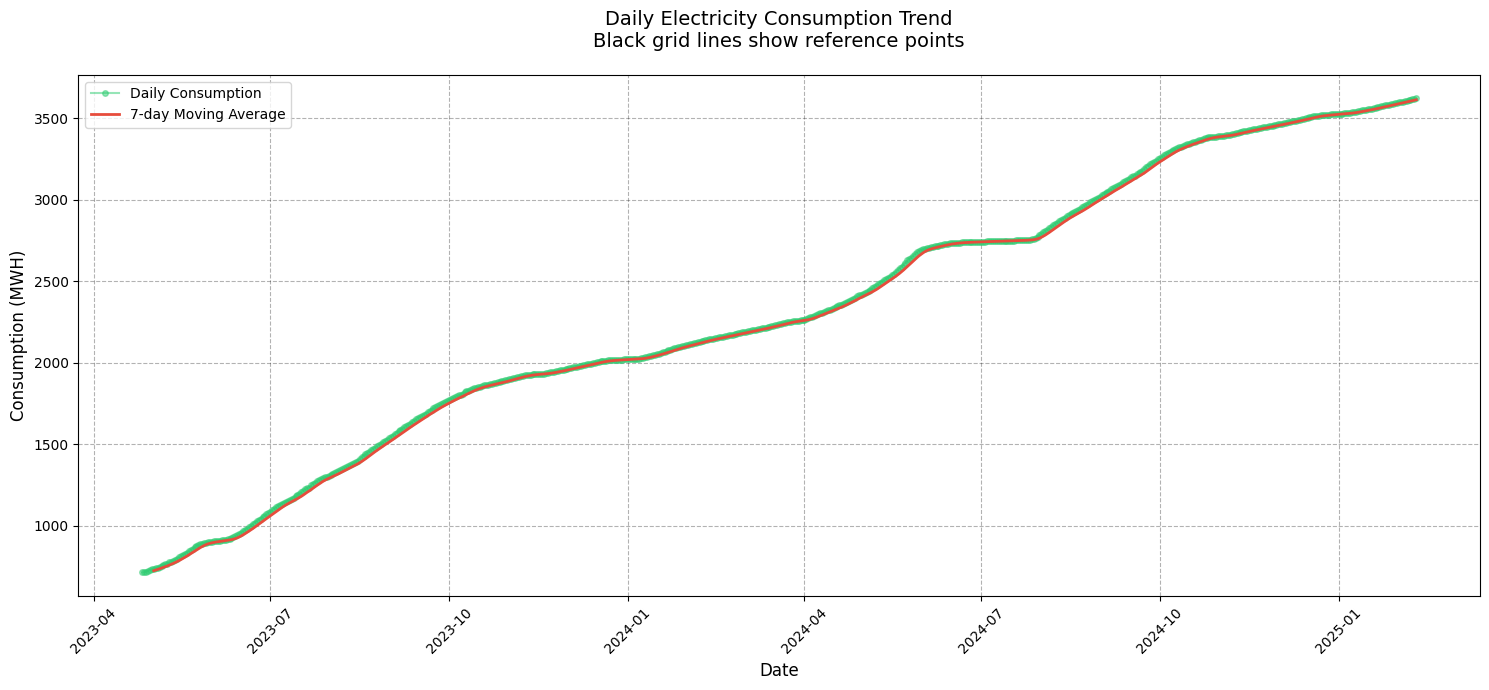

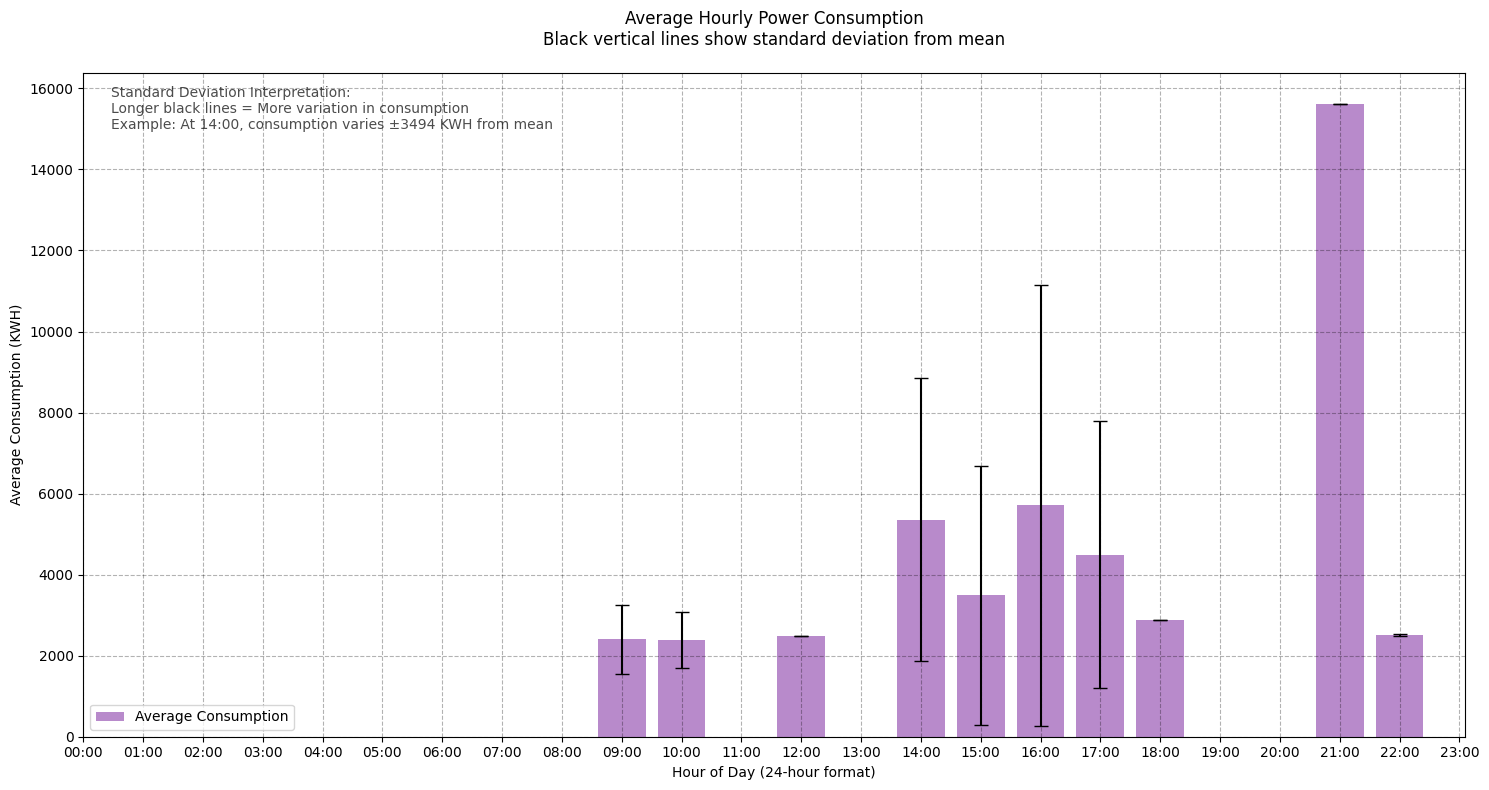

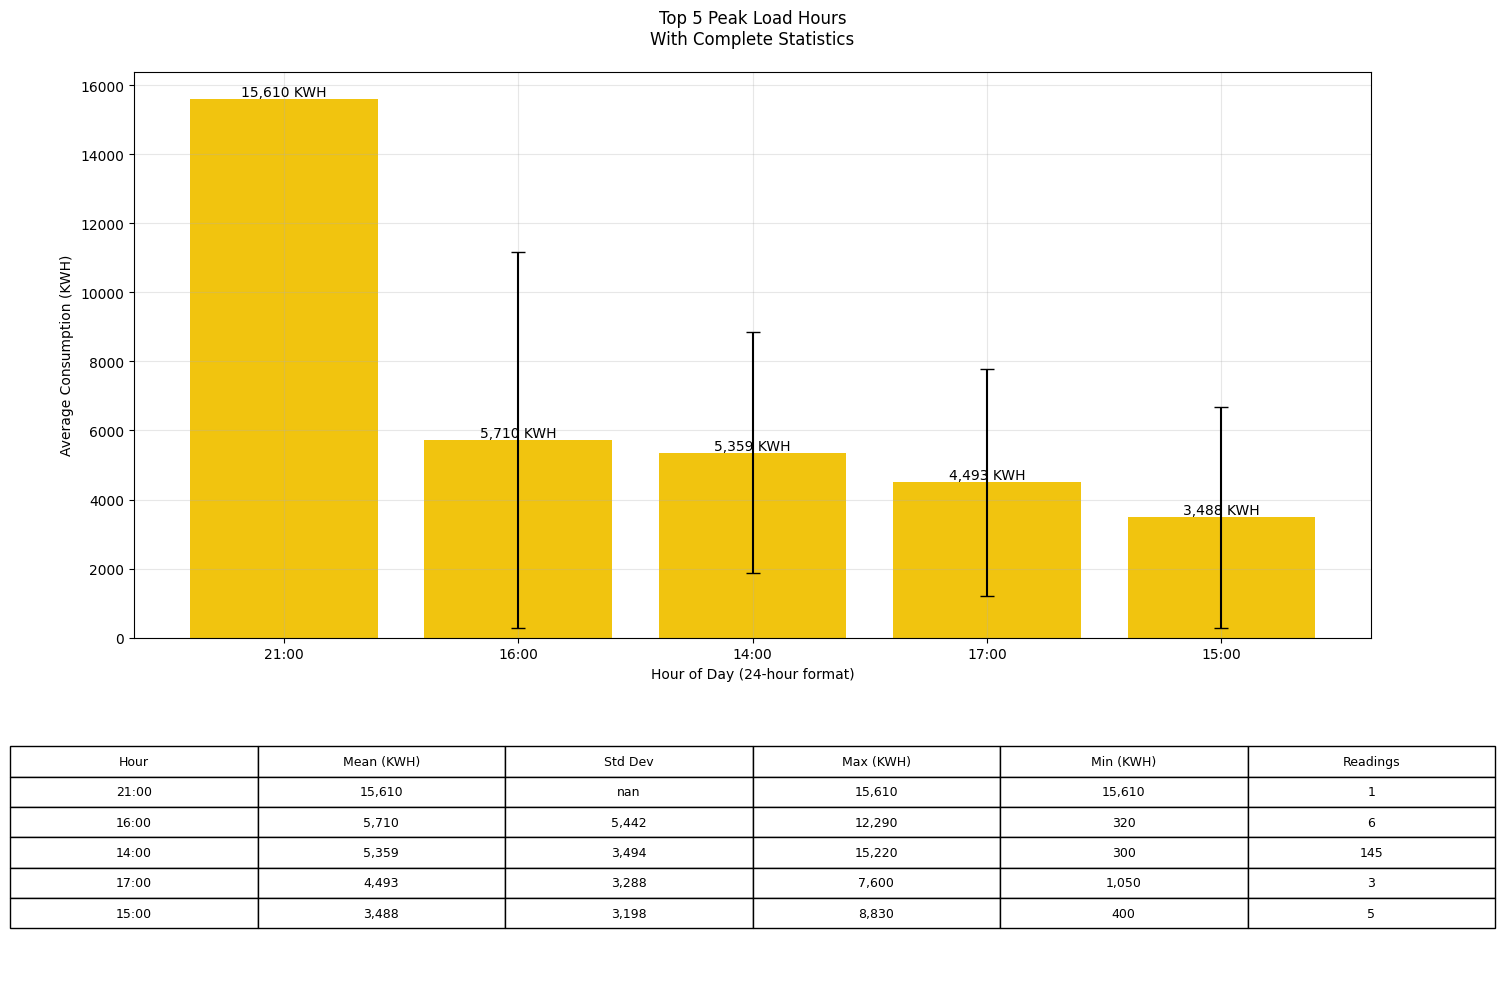


Top 5 Peak Consumption Hours Summary:

21:00 Statistics:
  Average: 15,610.00 KWH
  Std Dev: nan KWH
  Maximum: 15,610.00 KWH
  Minimum: 15,610.00 KWH
  Readings: 1

16:00 Statistics:
  Average: 5,710.00 KWH
  Std Dev: 5,442.34 KWH
  Maximum: 12,290.00 KWH
  Minimum: 320.00 KWH
  Readings: 6

14:00 Statistics:
  Average: 5,359.45 KWH
  Std Dev: 3,493.54 KWH
  Maximum: 15,220.00 KWH
  Minimum: 300.00 KWH
  Readings: 145

17:00 Statistics:
  Average: 4,493.33 KWH
  Std Dev: 3,287.95 KWH
  Maximum: 7,600.00 KWH
  Minimum: 1,050.00 KWH
  Readings: 3

15:00 Statistics:
  Average: 3,488.00 KWH
  Std Dev: 3,198.03 KWH
  Maximum: 8,830.00 KWH
  Minimum: 400.00 KWH
  Readings: 5

Analysis complete!


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import re

def extract_hour_from_string(time_str):
    """Extract hour from various time string formats"""
    if pd.isna(time_str):
        return None

    time_str = str(time_str).strip()
    time_pattern = r'(\d{1,2}):?\d{0,2}\s*(?:AM|PM|am|pm)?'
    match = re.search(time_pattern, time_str)

    if match:
        hour = int(match.group(1))
        if 'PM' in time_str.upper() and hour != 12:
            hour += 12
        elif 'AM' in time_str.upper() and hour == 12:
            hour = 0
        return hour
    return None

def load_and_preprocess_data():
    try:
        # Read main consumption data
        df_sheet1 = pd.read_csv('HO Unit Consumption - Sheet1.csv')
        print("Successfully loaded Sheet1")

        # Read feederwise consumption - skip first 2 rows as they contain headers
        df_feeder = pd.read_csv('HO Unit Consumption - Consumption Feederwise.csv', skiprows=2)
        print("Successfully loaded Feederwise data")

        # Clean and preprocess Sheet1
        df_sheet1 = df_sheet1.dropna(how='all')
        df_sheet1['Date'] = pd.to_datetime(df_sheet1['Date '].astype(str).str.strip(), format='%d-%b-%Y')

        # Convert numeric columns in Sheet1
        for col in df_sheet1.columns:
            if 'Unit' in col or 'Voltage' in col or 'Current' in col:
                df_sheet1[col] = pd.to_numeric(df_sheet1[col], errors='coerce')

        # Process feederwise data
        df_feeder.columns = ['S.No.', 'Date', 'Time & Temp', 'TR-1 KWH', 'TR-1 Voltage (V)',
                           'TR-1 Current (A)', 'AC Feeder from 1st to 8th Floor',
                           'AC Feeder Mess and Gnd Floor', 'Total Unit', 'Notes']

        # Convert date and extract time
        df_feeder['Date'] = pd.to_datetime(df_feeder['Date'].astype(str).str.strip(), format='%d-%b-%Y')
        df_feeder['Hour'] = df_feeder['Time & Temp'].apply(extract_hour_from_string)

        # Convert numeric columns (keeping outliers)
        numeric_cols = ['TR-1 KWH', 'TR-1 Voltage (V)', 'TR-1 Current (A)',
                       'AC Feeder from 1st to 8th Floor', 'AC Feeder Mess and Gnd Floor']

        for col in numeric_cols:
            if col in df_feeder.columns:
                df_feeder[col] = pd.to_numeric(df_feeder[col], errors='coerce')

        print("Successfully preprocessed data")
        return df_sheet1, df_feeder

    except Exception as e:
        print(f"Error in data processing: {str(e)}")
        import traceback
        print(traceback.format_exc())
        return None, None

def create_and_display_visualizations(df_sheet1, df_feeder):
    try:
        plt.style.use('default')

        # 1. Daily Consumption Trend
        plt.figure(figsize=(15, 7))
        daily_data = df_sheet1['Hostel-O Main I/C Unit in MWH']

        plt.plot(df_sheet1['Date'], daily_data,
                marker='o', linestyle='-', markersize=4, color='#2ecc71', alpha=0.5,
                label='Daily Consumption')

        # Add 7-day moving average
        ma7 = daily_data.rolling(window=7).mean()
        plt.plot(df_sheet1['Date'], ma7,
                linestyle='-', color='#e74c3c', linewidth=2,
                label='7-day Moving Average')

        plt.title('Daily Electricity Consumption Trend\nBlack grid lines show reference points',
                 fontsize=14, pad=20)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Consumption (MWH)', fontsize=12)
        plt.grid(True, alpha=0.3, color='black', linestyle='--')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # 2. Hourly Consumption Pattern with Standard Deviation
        valid_hours = df_feeder[df_feeder['Hour'].notna()]
        hourly_stats = valid_hours.groupby('Hour')['TR-1 KWH'].agg(['mean', 'std', 'count']).fillna(0)

        plt.figure(figsize=(15, 8))
        plt.bar(hourly_stats.index, hourly_stats['mean'],
               yerr=hourly_stats['std'], capsize=5,
               color='#9b59b6', alpha=0.7,
               label='Average Consumption')

        plt.title('Average Hourly Power Consumption\nBlack vertical lines show standard deviation from mean',
                 pad=20)
        plt.xlabel('Hour of Day (24-hour format)')
        plt.ylabel('Average Consumption (KWH)')
        plt.grid(True, alpha=0.3, color='black', linestyle='--')

        # Add detailed statistics annotation
        stats_text = "Standard Deviation Interpretation:\n"
        stats_text += "Longer black lines = More variation in consumption\n"
        stats_text += "Example: At 14:00, consumption varies ±{:.0f} KWH from mean"
        plt.text(0.02, 0.98, stats_text.format(hourly_stats.loc[14, 'std']),
                transform=plt.gca().transAxes, fontsize=10, alpha=0.7,
                verticalalignment='top')

        plt.xticks(range(0, 24), [f'{int(i):02d}:00' for i in range(0, 24)])
        plt.legend()
        plt.tight_layout()
        plt.show()

        # 3. Top 5 Peak Load Hours Analysis
        # Calculate statistics separately to avoid nested renamer error
        hourly_mean = valid_hours.groupby('Hour')['TR-1 KWH'].mean()
        hourly_std = valid_hours.groupby('Hour')['TR-1 KWH'].std()
        hourly_max = valid_hours.groupby('Hour')['TR-1 KWH'].max()
        hourly_min = valid_hours.groupby('Hour')['TR-1 KWH'].min()
        hourly_count = valid_hours.groupby('Hour')['TR-1 KWH'].count()

        # Get top 5 hours by mean consumption
        top_5_hours = hourly_mean.nlargest(5)

        # Create figure with complete statistics
        fig = plt.figure(figsize=(15, 10))
        gs = plt.GridSpec(2, 1, height_ratios=[2, 1])

        # Top subplot - bar chart
        ax1 = fig.add_subplot(gs[0])
        bars = ax1.bar(range(len(top_5_hours)), top_5_hours.values,
                      yerr=[hourly_std[hour] for hour in top_5_hours.index],
                      capsize=5,
                      color='#f1c40f')

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,} KWH',
                    ha='center', va='bottom')

        ax1.set_xticks(range(len(top_5_hours)))
        ax1.set_xticklabels([f'{int(hour):02d}:00' for hour in top_5_hours.index])
        ax1.set_title('Top 5 Peak Load Hours\nWith Complete Statistics', pad=20)
        ax1.set_xlabel('Hour of Day (24-hour format)')
        ax1.set_ylabel('Average Consumption (KWH)')
        ax1.grid(True, alpha=0.3)

        # Bottom subplot - detailed statistics table
        ax2 = fig.add_subplot(gs[1])
        cell_text = []
        for hour in top_5_hours.index:
            cell_text.append([
                f'{int(hour):02d}:00',
                f'{hourly_mean[hour]:,.0f}',
                f'{hourly_std[hour]:,.0f}',
                f'{hourly_max[hour]:,.0f}',
                f'{hourly_min[hour]:,.0f}',
                f'{hourly_count[hour]}'
            ])

        table = ax2.table(
            cellText=cell_text,
            colLabels=['Hour', 'Mean (KWH)', 'Std Dev', 'Max (KWH)', 'Min (KWH)', 'Readings'],
            loc='center',
            cellLoc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

        # Print peak hours summary
        print("\nTop 5 Peak Consumption Hours Summary:")
        for hour in top_5_hours.index:
            print(f"\n{int(hour):02d}:00 Statistics:")
            print(f"  Average: {hourly_mean[hour]:,.2f} KWH")
            print(f"  Std Dev: {hourly_std[hour]:,.2f} KWH")
            print(f"  Maximum: {hourly_max[hour]:,.2f} KWH")
            print(f"  Minimum: {hourly_min[hour]:,.2f} KWH")
            print(f"  Readings: {hourly_count[hour]}")

    except Exception as e:
        print(f"Error in creating visualizations: {str(e)}")
        import traceback
        print(traceback.format_exc())

def main():
    print("Loading and preprocessing data...")
    df_sheet1, df_feeder = load_and_preprocess_data()

    if df_sheet1 is None or df_feeder is None:
        print("Error: Could not process data")
        return

    print("\nGenerating and displaying visualizations...")
    create_and_display_visualizations(df_sheet1, df_feeder)

    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()

Loading and preprocessing data...
Successfully loaded Sheet1
Successfully loaded Feederwise data
Successfully preprocessed data

Generating and displaying basic visualizations...


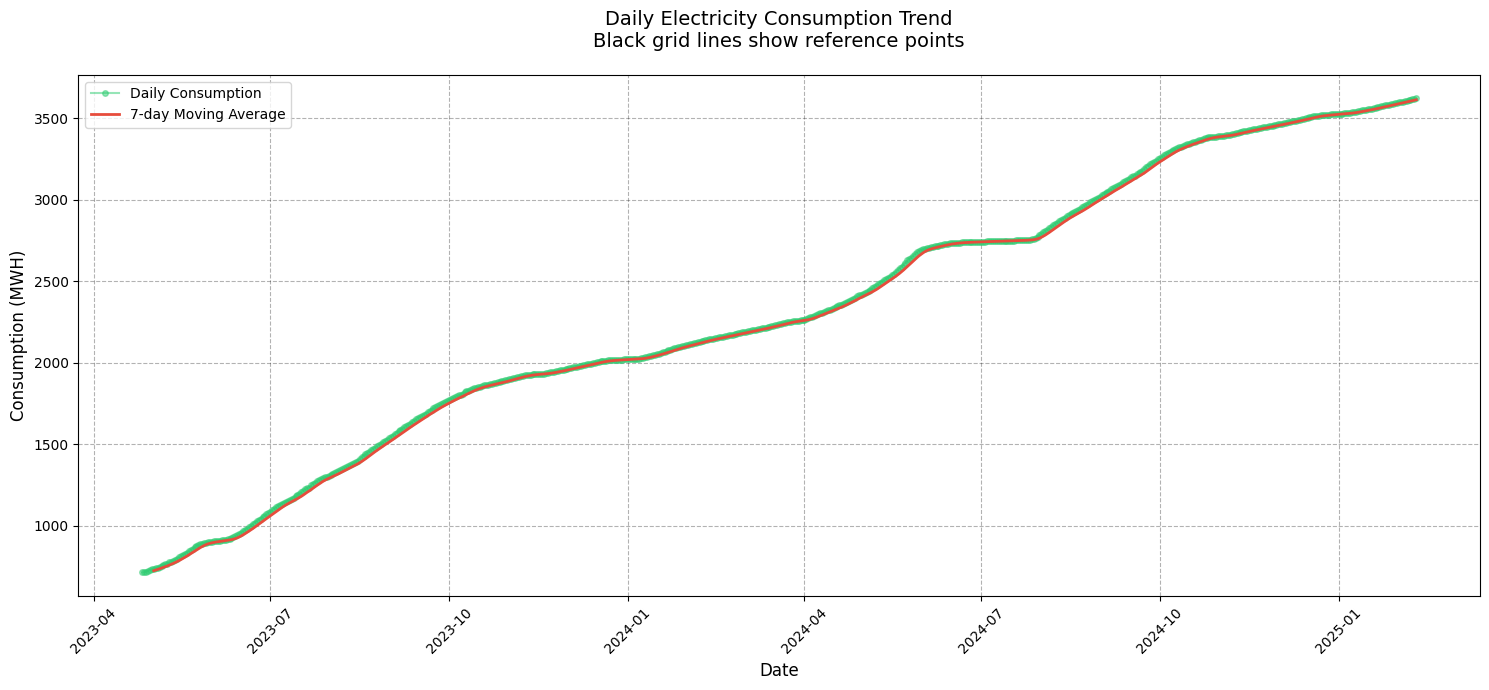

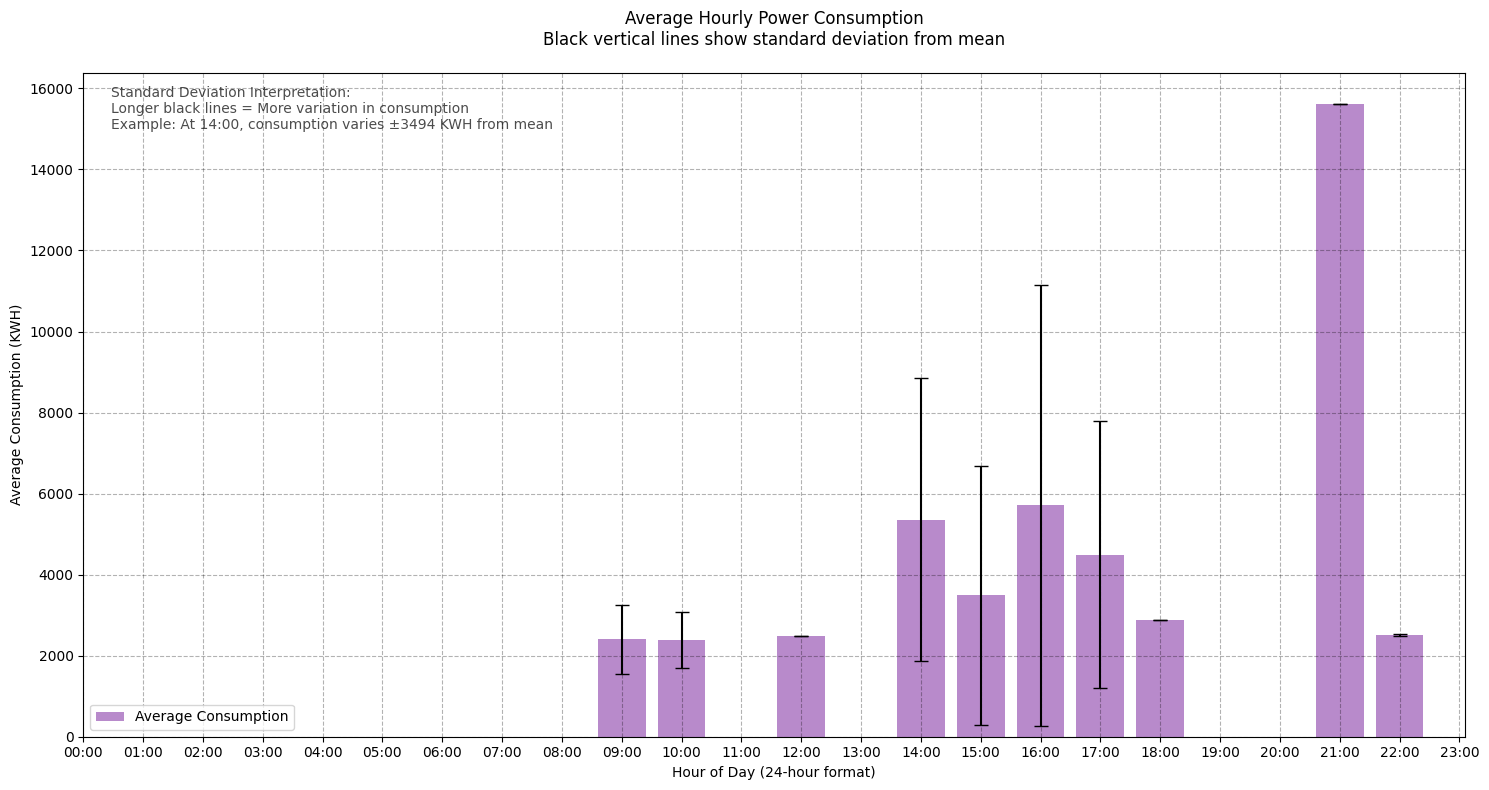

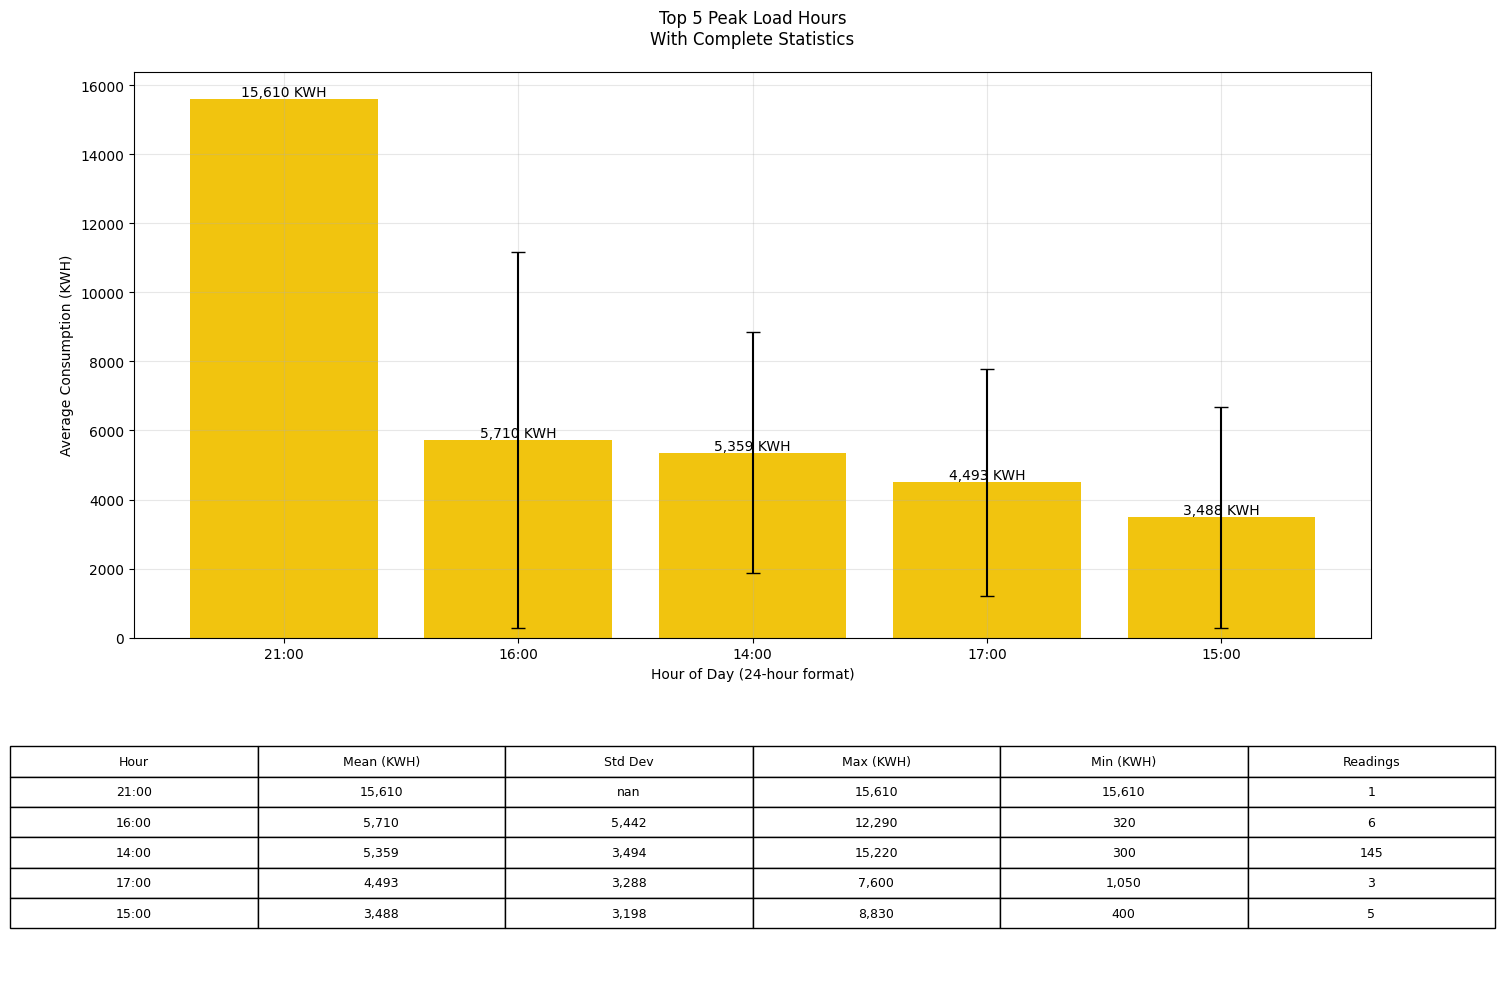


Top 5 Peak Consumption Hours Summary:

21:00 Statistics:
  Average: 15,610.00 KWH
  Std Dev: nan KWH
  Maximum: 15,610.00 KWH
  Minimum: 15,610.00 KWH
  Readings: 1

16:00 Statistics:
  Average: 5,710.00 KWH
  Std Dev: 5,442.34 KWH
  Maximum: 12,290.00 KWH
  Minimum: 320.00 KWH
  Readings: 6

14:00 Statistics:
  Average: 5,359.45 KWH
  Std Dev: 3,493.54 KWH
  Maximum: 15,220.00 KWH
  Minimum: 300.00 KWH
  Readings: 145

17:00 Statistics:
  Average: 4,493.33 KWH
  Std Dev: 3,287.95 KWH
  Maximum: 7,600.00 KWH
  Minimum: 1,050.00 KWH
  Readings: 3

15:00 Statistics:
  Average: 3,488.00 KWH
  Std Dev: 3,198.03 KWH
  Maximum: 8,830.00 KWH
  Minimum: 400.00 KWH
  Readings: 5

Generating and displaying temporal analysis...


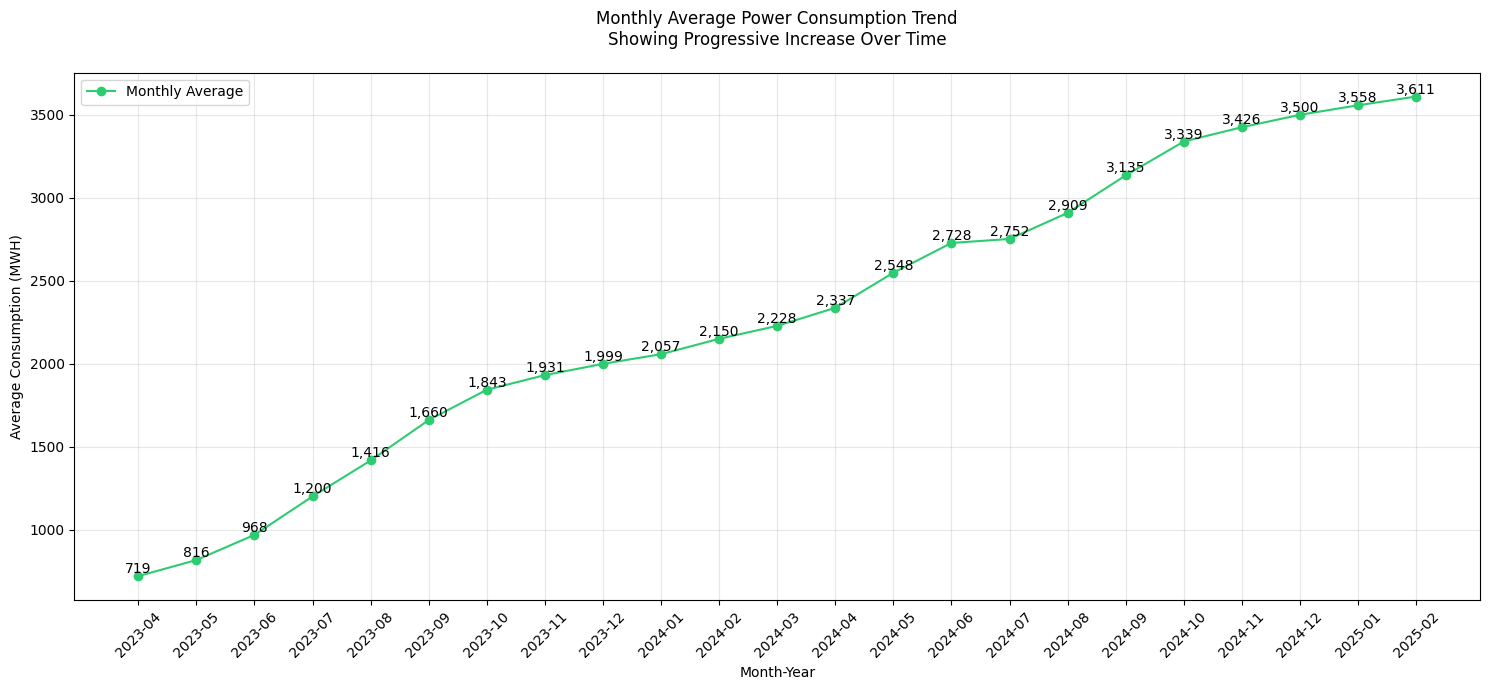

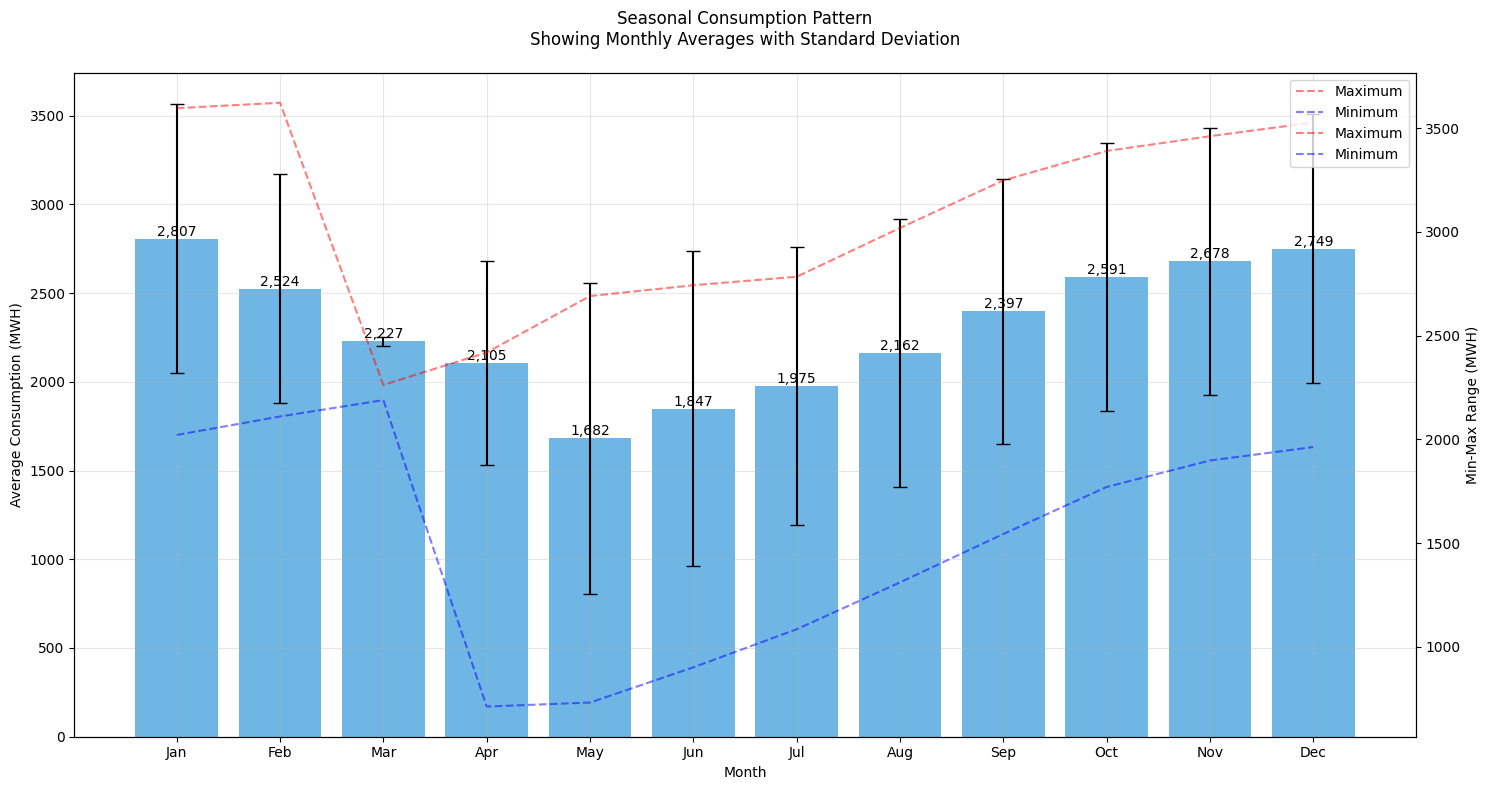


Temporal Analysis Summary:

Yearly Consumption Statistics:

Year 2023:
  Average Consumption: 1,463.41 MWH
  Minimum Consumption: 712.73 MWH
  Maximum Consumption: 2,020.88 MWH
  Year-over-Year Growth: 0.0%

Year 2024:
  Average Consumption: 2,760.87 MWH
  Minimum Consumption: 2,021.53 MWH
  Maximum Consumption: 3,527.54 MWH
  Year-over-Year Growth: 88.7%

Year 2025:
  Average Consumption: 3,570.77 MWH
  Minimum Consumption: 3,528.53 MWH
  Maximum Consumption: 3,622.54 MWH
  Year-over-Year Growth: 29.3%

Monthly Consumption Patterns:

January:
  Average Consumption: 2,807.55 MWH
  Minimum Consumption: 2,021.53 MWH
  Maximum Consumption: 3,596.40 MWH

February:
  Average Consumption: 2,524.43 MWH
  Minimum Consumption: 2,110.60 MWH
  Maximum Consumption: 3,622.54 MWH
  Month-over-Month Change: -10.1%

March:
  Average Consumption: 2,227.89 MWH
  Minimum Consumption: 2,189.52 MWH
  Maximum Consumption: 2,262.65 MWH
  Month-over-Month Change: -11.7%

April:
  Average Consumption: 2,105.7

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import re

def extract_hour_from_string(time_str):
    """Extract hour from various time string formats"""
    if pd.isna(time_str):
        return None

    time_str = str(time_str).strip()
    time_pattern = r'(\d{1,2}):?\d{0,2}\s*(?:AM|PM|am|pm)?'
    match = re.search(time_pattern, time_str)

    if match:
        hour = int(match.group(1))
        if 'PM' in time_str.upper() and hour != 12:
            hour += 12
        elif 'AM' in time_str.upper() and hour == 12:
            hour = 0
        return hour
    return None

def load_and_preprocess_data():
    try:
        # Read main consumption data
        df_sheet1 = pd.read_csv('HO Unit Consumption - Sheet1.csv')
        print("Successfully loaded Sheet1")

        # Read feederwise consumption - skip first 2 rows as they contain headers
        df_feeder = pd.read_csv('HO Unit Consumption - Consumption Feederwise.csv', skiprows=2)
        print("Successfully loaded Feederwise data")

        # Clean and preprocess Sheet1
        df_sheet1 = df_sheet1.dropna(how='all')
        df_sheet1['Date'] = pd.to_datetime(df_sheet1['Date '].astype(str).str.strip(), format='%d-%b-%Y')

        # Convert numeric columns in Sheet1
        for col in df_sheet1.columns:
            if 'Unit' in col or 'Voltage' in col or 'Current' in col:
                df_sheet1[col] = pd.to_numeric(df_sheet1[col], errors='coerce')

        # Process feederwise data
        df_feeder.columns = ['S.No.', 'Date', 'Time & Temp', 'TR-1 KWH', 'TR-1 Voltage (V)',
                           'TR-1 Current (A)', 'AC Feeder from 1st to 8th Floor',
                           'AC Feeder Mess and Gnd Floor', 'Total Unit', 'Notes']

        # Convert date and extract time
        df_feeder['Date'] = pd.to_datetime(df_feeder['Date'].astype(str).str.strip(), format='%d-%b-%Y')
        df_feeder['Hour'] = df_feeder['Time & Temp'].apply(extract_hour_from_string)

        # Convert numeric columns (keeping outliers)
        numeric_cols = ['TR-1 KWH', 'TR-1 Voltage (V)', 'TR-1 Current (A)',
                       'AC Feeder from 1st to 8th Floor', 'AC Feeder Mess and Gnd Floor']

        for col in numeric_cols:
            if col in df_feeder.columns:
                df_feeder[col] = pd.to_numeric(df_feeder[col], errors='coerce')

        print("Successfully preprocessed data")
        return df_sheet1, df_feeder

    except Exception as e:
        print(f"Error in data processing: {str(e)}")
        import traceback
        print(traceback.format_exc())
        return None, None

def create_and_display_visualizations(df_sheet1, df_feeder):
    try:
        plt.style.use('default')

        # 1. Daily Consumption Trend
        plt.figure(figsize=(15, 7))
        daily_data = df_sheet1['Hostel-O Main I/C Unit in MWH']

        plt.plot(df_sheet1['Date'], daily_data,
                marker='o', linestyle='-', markersize=4, color='#2ecc71', alpha=0.5,
                label='Daily Consumption')

        # Add 7-day moving average
        ma7 = daily_data.rolling(window=7).mean()
        plt.plot(df_sheet1['Date'], ma7,
                linestyle='-', color='#e74c3c', linewidth=2,
                label='7-day Moving Average')

        plt.title('Daily Electricity Consumption Trend\nBlack grid lines show reference points',
                 fontsize=14, pad=20)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Consumption (MWH)', fontsize=12)
        plt.grid(True, alpha=0.3, color='black', linestyle='--')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # 2. Hourly Consumption Pattern with Standard Deviation
        valid_hours = df_feeder[df_feeder['Hour'].notna()]
        hourly_stats = valid_hours.groupby('Hour')['TR-1 KWH'].agg(['mean', 'std', 'count']).fillna(0)

        plt.figure(figsize=(15, 8))
        plt.bar(hourly_stats.index, hourly_stats['mean'],
               yerr=hourly_stats['std'], capsize=5,
               color='#9b59b6', alpha=0.7,
               label='Average Consumption')

        plt.title('Average Hourly Power Consumption\nBlack vertical lines show standard deviation from mean',
                 pad=20)
        plt.xlabel('Hour of Day (24-hour format)')
        plt.ylabel('Average Consumption (KWH)')
        plt.grid(True, alpha=0.3, color='black', linestyle='--')

        # Add detailed statistics annotation
        stats_text = "Standard Deviation Interpretation:\n"
        stats_text += "Longer black lines = More variation in consumption\n"
        stats_text += "Example: At 14:00, consumption varies ±{:.0f} KWH from mean"
        plt.text(0.02, 0.98, stats_text.format(hourly_stats.loc[14, 'std']),
                transform=plt.gca().transAxes, fontsize=10, alpha=0.7,
                verticalalignment='top')

        plt.xticks(range(0, 24), [f'{int(i):02d}:00' for i in range(0, 24)])
        plt.legend()
        plt.tight_layout()
        plt.show()

        # 3. Top 5 Peak Load Hours Analysis
        # Calculate statistics separately to avoid nested renamer error
        hourly_mean = valid_hours.groupby('Hour')['TR-1 KWH'].mean()
        hourly_std = valid_hours.groupby('Hour')['TR-1 KWH'].std()
        hourly_max = valid_hours.groupby('Hour')['TR-1 KWH'].max()
        hourly_min = valid_hours.groupby('Hour')['TR-1 KWH'].min()
        hourly_count = valid_hours.groupby('Hour')['TR-1 KWH'].count()

        # Get top 5 hours by mean consumption
        top_5_hours = hourly_mean.nlargest(5)

        # Create figure with complete statistics
        fig = plt.figure(figsize=(15, 10))
        gs = plt.GridSpec(2, 1, height_ratios=[2, 1])

        # Top subplot - bar chart
        ax1 = fig.add_subplot(gs[0])
        bars = ax1.bar(range(len(top_5_hours)), top_5_hours.values,
                      yerr=[hourly_std[hour] for hour in top_5_hours.index],
                      capsize=5,
                      color='#f1c40f')

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,} KWH',
                    ha='center', va='bottom')

        ax1.set_xticks(range(len(top_5_hours)))
        ax1.set_xticklabels([f'{int(hour):02d}:00' for hour in top_5_hours.index])
        ax1.set_title('Top 5 Peak Load Hours\nWith Complete Statistics', pad=20)
        ax1.set_xlabel('Hour of Day (24-hour format)')
        ax1.set_ylabel('Average Consumption (KWH)')
        ax1.grid(True, alpha=0.3)

        # Bottom subplot - detailed statistics table
        ax2 = fig.add_subplot(gs[1])
        cell_text = []
        for hour in top_5_hours.index:
            cell_text.append([
                f'{int(hour):02d}:00',
                f'{hourly_mean[hour]:,.0f}',
                f'{hourly_std[hour]:,.0f}',
                f'{hourly_max[hour]:,.0f}',
                f'{hourly_min[hour]:,.0f}',
                f'{hourly_count[hour]}'
            ])

        table = ax2.table(
            cellText=cell_text,
            colLabels=['Hour', 'Mean (KWH)', 'Std Dev', 'Max (KWH)', 'Min (KWH)', 'Readings'],
            loc='center',
            cellLoc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

        # Print peak hours summary
        print("\nTop 5 Peak Consumption Hours Summary:")
        for hour in top_5_hours.index:
            print(f"\n{int(hour):02d}:00 Statistics:")
            print(f"  Average: {hourly_mean[hour]:,.2f} KWH")
            print(f"  Std Dev: {hourly_std[hour]:,.2f} KWH")
            print(f"  Maximum: {hourly_max[hour]:,.2f} KWH")
            print(f"  Minimum: {hourly_min[hour]:,.2f} KWH")
            print(f"  Readings: {hourly_count[hour]}")

    except Exception as e:
        print(f"Error in creating visualizations: {str(e)}")
        import traceback
        print(traceback.format_exc())

def create_temporal_analysis(df_sheet1, df_feeder):
    """Create visualizations for annual and monthly patterns"""
    try:
        # Add month and year columns
        df_sheet1['Month'] = df_sheet1['Date'].dt.month
        df_sheet1['Year'] = df_sheet1['Date'].dt.year
        df_sheet1['MonthYear'] = df_sheet1['Date'].dt.to_period('M')

        # 1. Monthly Average Consumption Pattern with Year-wise Trend
        plt.figure(figsize=(15, 7))
        monthly_avg = df_sheet1.groupby('MonthYear')['Hostel-O Main I/C Unit in MWH'].mean()

        plt.plot(range(len(monthly_avg)), monthly_avg.values,
                marker='o', linestyle='-', color='#2ecc71',
                label='Monthly Average')

        # Add value labels
        for i, value in enumerate(monthly_avg.values):
            plt.text(i, value, f'{value:,.0f}', ha='center', va='bottom')

        plt.title('Monthly Average Power Consumption Trend\nShowing Progressive Increase Over Time', pad=20)
        plt.xlabel('Month-Year')
        plt.ylabel('Average Consumption (MWH)')
        plt.grid(True, alpha=0.3)
        plt.xticks(range(len(monthly_avg)),
                  [str(date) for date in monthly_avg.index],
                  rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # 2. Seasonal Pattern Analysis with Error Bars
        plt.figure(figsize=(15, 8))
        seasonal_avg = df_sheet1.groupby('Month')['Hostel-O Main I/C Unit in MWH'].agg(['mean', 'std', 'min', 'max'])

        # Create bar plot with error bars
        bars = plt.bar(range(1, 13), seasonal_avg['mean'],
                      yerr=seasonal_avg['std'],
                      capsize=5,
                      color='#3498db',
                      alpha=0.7,
                      label='Monthly Average')

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}',
                    ha='center', va='bottom')

        plt.title('Seasonal Consumption Pattern\nShowing Monthly Averages with Standard Deviation', pad=20)
        plt.xlabel('Month')
        plt.ylabel('Average Consumption (MWH)')
        plt.grid(True, alpha=0.3)
        plt.xticks(range(1, 13),
                  ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

        # Add secondary y-axis for min-max range
        ax2 = plt.twinx()
        ax2.plot(range(1, 13), seasonal_avg['max'], 'r--', alpha=0.5, label='Maximum')
        ax2.plot(range(1, 13), seasonal_avg['min'], 'b--', alpha=0.5, label='Minimum')
        ax2.set_ylabel('Min-Max Range (MWH)')

        # Combine legends
        lines1, labels1 = plt.gca().get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print("\nTemporal Analysis Summary:")

        # Yearly statistics
        print("\nYearly Consumption Statistics:")
        yearly_stats = df_sheet1.groupby('Year')['Hostel-O Main I/C Unit in MWH'].agg(['mean', 'min', 'max'])
        for year in yearly_stats.index:
            print(f"\nYear {year:.0f}:")
            print(f"  Average Consumption: {yearly_stats.loc[year, 'mean']:,.2f} MWH")
            print(f"  Minimum Consumption: {yearly_stats.loc[year, 'min']:,.2f} MWH")
            print(f"  Maximum Consumption: {yearly_stats.loc[year, 'max']:,.2f} MWH")
            print(f"  Year-over-Year Growth: {((yearly_stats.loc[year, 'mean'] / yearly_stats.loc[year-1, 'mean'] if year > yearly_stats.index[0] else 1) - 1) * 100:.1f}%")

        # Monthly patterns with percent change
        print("\nMonthly Consumption Patterns:")
        monthly_stats = df_sheet1.groupby('Month')['Hostel-O Main I/C Unit in MWH'].agg(['mean', 'min', 'max'])
        months = ['January', 'February', 'March', 'April', 'May', 'June',
                 'July', 'August', 'September', 'October', 'November', 'December']

        prev_month_avg = None
        for month in range(1, 13):
            if month in monthly_stats.index:
                curr_month_avg = monthly_stats.loc[month, 'mean']
                month_change = ((curr_month_avg / prev_month_avg - 1) * 100) if prev_month_avg else 0

                print(f"\n{months[month-1]}:")
                print(f"  Average Consumption: {curr_month_avg:,.2f} MWH")
                print(f"  Minimum Consumption: {monthly_stats.loc[month, 'min']:,.2f} MWH")
                print(f"  Maximum Consumption: {monthly_stats.loc[month, 'max']:,.2f} MWH")
                if prev_month_avg:
                    print(f"  Month-over-Month Change: {month_change:+.1f}%")

                prev_month_avg = curr_month_avg

    except Exception as e:
        print(f"Error in temporal analysis: {str(e)}")
        import traceback
        print(traceback.format_exc())

def main():
    print("Loading and preprocessing data...")
    df_sheet1, df_feeder = load_and_preprocess_data()

    if df_sheet1 is None or df_feeder is None:
        print("Error: Could not process data")
        return

    print("\nGenerating and displaying basic visualizations...")
    create_and_display_visualizations(df_sheet1, df_feeder)

    print("\nGenerating and displaying temporal analysis...")
    create_temporal_analysis(df_sheet1, df_feeder)

    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()